In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import math
import random

In [2]:
meds = pd.read_csv('meds_simplified.csv')
diag = pd.read_csv('diagnosis_simplified.csv')

print(meds.shape)
meds.head(n=1)

print(diag.shape)
diag.head(n=1)

(1187, 8)
(1338, 9)


,patient_id,encounter_id,encounter_date,patient_sex,patient_age,smoker_status,measure_1,measure_2,condition
1,220,1,2067-05-03,female,55,past,NaN,NaN,HYPERLIPIDEMIA


In [3]:
df = pd.merge(diag, meds, on=['patient_id', 'encounter_id', 'condition',
                                'encounter_date', 'patient_sex', 'patient_age',
                               'smoker_status'], how='outer')
print(df.shape)
mask = (df.patient_id == 221)

df[mask]

(1671, 10)


,patient_id,encounter_id,encounter_date,patient_sex,patient_age,smoker_status,measure_1,measure_2,condition,condition_medication
18,221.0,1.0,2088-07-03,male,64,never,NaN,NaN,HYPERLIPIDEMIA,NaN
19,221.0,1.0,2088-07-03,male,64,never,NaN,NaN,HYPERTENSION,nitrate; beta blocker
20,221.0,1.0,2088-07-03,male,64,never,NaN,NaN,CAD,statin; aspirin
21,221.0,2.0,2089-10-07,male,NaN,unknown,NaN,NaN,HYPERLIPIDEMIA,NaN
22,221.0,2.0,2089-10-07,male,NaN,unknown,155.0,77.5,HYPERTENSION,ARB; beta blocker; diuretic
23,221.0,2.0,2089-10-07,male,NaN,unknown,NaN,NaN,CAD,statin
24,221.0,3.0,2091-11-15,male,NaN,unknown,NaN,NaN,HYPERTENSION,nitrate
25,221.0,3.0,2091-11-15,male,NaN,unknown,NaN,NaN,CAD,NaN
26,221.0,4.0,2092-03-15,male,67,NaN,NaN,NaN,CAD,aspirin
27,221.0,5.0,2093-07-04,male,68,never,NaN,NaN,HYPERLIPIDEMIA,NaN


In [4]:
  
df['all_medication'] = None    


for i, data_row in df.iterrows():
    #per_encounter
    encounter_mask = (df['patient_id'] == data_row.patient_id) & (df['encounter_id'] == data_row.encounter_id)
    encounter_group = df[encounter_mask]
    
    #combine meds and diagnosis
    df.loc[i, 'all_medication'] = '; '.join(
        encounter_group.condition_medication[encounter_group.condition_medication.notnull()])
    
    patient_mask = (df['patient_id'] == data_row.patient_id)
    patient_group = df[patient_mask]
    
    #homogenize demographics
    if pd.isnull(df.loc[i, 'patient_sex']):
        all_sex = list(set(patient_group.patient_sex[patient_group.patient_sex.notnull()]))
        df.loc[i, 'patient_sex'] = '; '.join(all_sex)
        
    if pd.isnull(df.loc[i, 'patient_age']):
        all_ages = list(set(patient_group.patient_age[patient_group.patient_age.notnull()]))
        all_ages.sort()
        
        try:
            youngest = all_ages[0]
            first_date = list(patient_group.encounter_date[patient_group.patient_age == youngest])[0]
            this_date = df.loc[i, 'encounter_date']
            
            try:
                first_date = dt.datetime.strptime(first_date, '%Y-%m-%d')
                this_date = dt.datetime.strptime(this_date, '%Y-%m-%d')
                diff = this_date - first_date
                new_age = int(youngest) + int(diff.days / 365)

                df.loc[i, 'patient_age'] = new_age
            except ValueError:
                pass
        except IndexError:
            pass

        
    if (df.loc[i, 'smoker_status'] == 'unknown') or pd.isnull(df.loc[i, 'smoker_status']):
        all_smoke = list(set(patient_group.smoker_status[
                    (patient_group.smoker_status != 'unknown') &
                    (patient_group.smoker_status.notnull())
                ]))
        df.loc[i, 'smoker_status'] = '; '.join(all_smoke)

mask = (df.patient_id == 221)
df[mask]

,patient_id,encounter_id,encounter_date,patient_sex,patient_age,smoker_status,measure_1,measure_2,condition,condition_medication,all_medication
18,221.0,1.0,2088-07-03,male,64,never,NaN,NaN,HYPERLIPIDEMIA,NaN,nitrate; beta blocker; statin; aspirin
19,221.0,1.0,2088-07-03,male,64,never,NaN,NaN,HYPERTENSION,nitrate; beta blocker,nitrate; beta blocker; statin; aspirin
20,221.0,1.0,2088-07-03,male,64,never,NaN,NaN,CAD,statin; aspirin,nitrate; beta blocker; statin; aspirin
21,221.0,2.0,2089-10-07,male,65,never,NaN,NaN,HYPERLIPIDEMIA,NaN,ARB; beta blocker; diuretic; statin
22,221.0,2.0,2089-10-07,male,65,never,155.0,77.5,HYPERTENSION,ARB; beta blocker; diuretic,ARB; beta blocker; diuretic; statin
23,221.0,2.0,2089-10-07,male,65,never,NaN,NaN,CAD,statin,ARB; beta blocker; diuretic; statin
24,221.0,3.0,2091-11-15,male,67,never,NaN,NaN,HYPERTENSION,nitrate,nitrate
25,221.0,3.0,2091-11-15,male,67,never,NaN,NaN,CAD,NaN,nitrate
26,221.0,4.0,2092-03-15,male,67,never,NaN,NaN,CAD,aspirin,aspirin; nitrate
27,221.0,5.0,2093-07-04,male,68,never,NaN,NaN,HYPERLIPIDEMIA,NaN,statin; thienopyridine; aspirin; ARB; beta blo...


In [5]:
blood = 'HYPERTENSION'
lipid = 'HYPERLIPIDEMIA'
sugar = 'DIABETES'
cad = 'CAD'
fat = 'OBESE'

set(df.condition_medication[df.condition == sugar])

{nan,
 'DPP4 inhibitors; metformin; insulin',
 'insulin',
 'metformin',
 'metformin; insulin',
 'sulfonylureas',
 'sulfonylureas; insulin',
 'sulfonylureas; metformin',
 'sulfonylureas; metformin; insulin',
 'sulfonylureas; thiazolidinedione',
 'sulfonylureas; thiazolidinedione; metformin',
 'thiazolidinedione',
 'thiazolidinedione; insulin',
 'thiazolidinedione; metformin',
 'thiazolidinedione; metformin; insulin'}

In [6]:
df['is_male'] = 0
df['ever_smoked'] = 0

for i, data_row in df.iterrows():
    #fix dates
    if isinstance(data_row.loc['encounter_date'], basestring):
        date_string = data_row.loc['encounter_date']
        if len(data_row.loc['encounter_date']) == 8:
            date_string = date_string.split('/')
            date_string[-1] = '20' + date_string[-1]
            date_string = '/'.join(date_string)
            try:
                df.loc[i, 'encounter_date'] = dt.datetime.strptime(date_string, '%m/%d/%Y')
            except ValueError:
                df.loc[i, 'encounter_date'] = dt.datetime.strptime(date_string, '%Y-%m-%d')
        
    
    #fix ages
    try: 
        df.loc[i, 'patient_age'] = int(data_row.loc['patient_age'])
    except ValueError:
        if pd.notnull(data_row.loc['patient_age']):
            # all in the form 40s or simialr. Set to 45
            df.loc[i, 'patient_age'] = int(data_row.loc['patient_age'][:2]) + 5 
    
    #reformat sex, smoker_status
    if data_row['smoker_status'] in ['past', 'current', 'ever']:
        df.loc[i, 'ever_smoked'] = 1
    elif data_row['smoker_status'] in ['never']:
        df.loc[i, 'ever_smoked'] = 0
    else:
        df.loc[i, 'ever_smoked'] = np.nan
    
    if data_row['patient_sex'] == 'male':
        df.loc[i, 'is_male'] = 1
    else:
        df.loc[i, 'is_male'] = 0

df['encounter_date'] = pd.to_datetime(df['encounter_date'])
df['patient_age'] = df['patient_age'].astype(float)
df['patient_id'] = df['patient_id'].astype(int)
df['encounter_id'] = df['encounter_id'].astype(int)

df = df.drop(['smoker_status','patient_sex'], 1)

In [7]:
all_diag = [blood, lipid, sugar, cad, fat]
all_diag.sort()
print(all_diag)


all_meds = "; ".join([str(x) for x in list(df.all_medication)])
all_meds = all_meds.split('; ')
all_meds = list(set(all_meds))
all_meds = [x.replace(' ', '_') for x in all_meds]
all_meds.remove('')
all_meds.sort()
print(all_meds)

['CAD', 'DIABETES', 'HYPERLIPIDEMIA', 'HYPERTENSION', 'OBESE']
['ACE_inhibitor', 'ARB', 'DPP4_inhibitors', 'aspirin', 'beta_blocker', 'calcium_channel_blocker', 'diuretic', 'ezetimibe', 'fibrate', 'insulin', 'metformin', 'niacin', 'nitrate', 'statin', 'sulfonylureas', 'thiazolidinedione', 'thienopyridine']


In [8]:
for each in all_meds:
    df.loc[:, each] = 0
for each in all_diag:
    df.loc[:, each] = 0

for i, data_row in df.iterrows():
    for each_med in all_meds:
        meds = str(data_row.all_medication).split('; ')
        meds = [x.replace(' ', '_') for x in meds]  
        
        if each_med in ' '.join(meds):
            df.loc[i, each_med] = 1
            
    for each_diag in all_diag:
        group = list(df.condition[((df.patient_id == data_row.patient_id) & 
                                   (df.encounter_id == data_row.encounter_id))])
        if each_diag in group:
            df.loc[i, each_diag] = 1

In [9]:
df = df[df.measure_1.notnull()]
print(len(list(set(df.patient_id))))
df.head()


101


,patient_id,encounter_id,encounter_date,patient_age,measure_1,measure_2,condition,condition_medication,all_medication,is_male,...,nitrate,statin,sulfonylureas,thiazolidinedione,thienopyridine,CAD,DIABETES,HYPERLIPIDEMIA,HYPERTENSION,OBESE
1,220,1,2067-05-03,55.0,157.14,77.14,HYPERTENSION,nitrate; beta blocker; calcium channel blocker...,nitrate; beta blocker; calcium channel blocker...,0,...,1,1,0,0,1,1,0,1,1,0
6,220,3,2070-12-01,37.0,119.00,NaN,HYPERLIPIDEMIA,NaN,nitrate; beta blocker; calcium channel blocker...,0,...,1,1,0,0,0,1,0,1,1,0
9,220,4,2072-07-27,37.0,108.00,NaN,HYPERLIPIDEMIA,NaN,nitrate; beta blocker; calcium channel blocker...,0,...,1,1,0,0,0,1,0,1,1,1
11,220,4,2072-07-27,37.0,148.00,76.00,HYPERTENSION,nitrate; beta blocker; calcium channel blocker...,nitrate; beta blocker; calcium channel blocker...,0,...,1,1,0,0,0,1,0,1,1,1
16,220,5,2075-01-31,37.0,148.00,66.00,HYPERTENSION,nitrate; beta blocker; calcium channel blocker...,statin; aspirin; nitrate; beta blocker; calciu...,0,...,1,1,0,0,0,1,1,1,1,1


In [10]:
print(df.shape)
df.describe()

(267, 33)


/home/keziah/anaconda2/envs/my_projects_env/lib/python2.7/site-packages/numpy/lib/function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


,patient_id,encounter_id,patient_age,measure_1,measure_2,is_male,ever_smoked,ACE_inhibitor,ARB,DPP4_inhibitors,...,nitrate,statin,sulfonylureas,thiazolidinedione,thienopyridine,CAD,DIABETES,HYPERLIPIDEMIA,HYPERTENSION,OBESE
count,267.000000,267.000000,254.000000,267.000000,221.000000,267.000000,229.000000,267.000000,267.000000,267.000000,...,267.000000,267.000000,267.000000,267.000000,267.000000,267.000000,267.000000,267.000000,267.0,267.000000
mean,312.449438,2.808989,63.181102,150.867841,89.804977,0.434457,0.423581,0.561798,0.131086,0.003745,...,0.194757,0.625468,0.250936,0.074906,0.108614,0.831461,0.794007,0.516854,1.0,0.209738
std,50.964313,1.361747,14.874132,128.881059,51.695226,0.496616,0.495208,0.497098,0.338128,0.061199,...,0.396757,0.484911,0.434366,0.263735,0.311739,0.375048,0.405185,0.500654,0.0,0.407886
min,220.000000,1.000000,14.000000,3.010000,50.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000
25%,277.500000,2.000000,NaN,140.500000,NaN,0.000000,NaN,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.0,0.000000
50%,309.000000,3.000000,NaN,150.000000,NaN,0.000000,NaN,1.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.0,0.000000
75%,357.000000,4.000000,NaN,166.000000,NaN,1.000000,NaN,1.000000,0.000000,0.000000,...,0.000000,1.000000,0.500000,0.000000,0.000000,1.000000,1.000000,1.000000,1.0,0.000000
max,400.000000,5.000000,88.000000,2081.000000,637.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000


In [11]:
#Fix patient 220 age
print(df[df.patient_id == 220]).patient_age
df.loc[(df.patient_id == 220), 'patient_age'] = 55
print(df[df.patient_id == 220]).patient_age

1     55.0
6     37.0
9     37.0
11    37.0
16    37.0
17    37.0
Name: patient_age, dtype: float64
1     55.0
6     55.0
9     55.0
11    55.0
16    55.0
17    55.0
Name: patient_age, dtype: float64


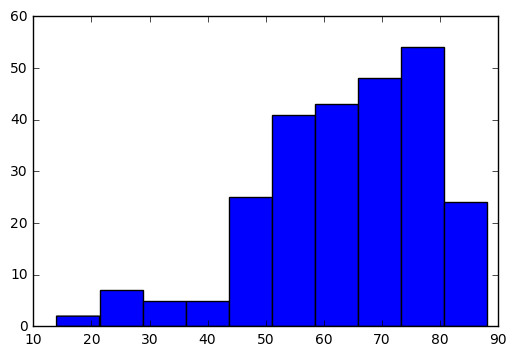

In [12]:
df_age = df[df.patient_age > 0]
plt.hist(df_age.patient_age.values)
plt.show()

In [13]:
df_young = df[df.patient_age < 45]
print(zip(df_young.patient_id, df_young.encounter_id, df_young.patient_age))

#good: 246, 
#Nan: 279.1, 279.5 but 279.2 == 76
#good 301, 304, 322, 326, 
df.loc[(df.patient_age < 20), 'patient_age'] = np.nan

[(246, 2, 40.0), (279, 1, 14.0), (279, 5, 15.0), (301, 1, 39.0), (301, 2, 42.0), (304, 1, 27.0), (304, 2, 27.0), (304, 3, 27.0), (304, 4, 28.0), (304, 5, 28.0), (304, 5, 28.0), (322, 1, 31.0), (322, 5, 33.0), (326, 1, 28.0), (326, 4, 30.0), (326, 5, 32.0), (338, 2, 36.0), (338, 3, 39.0), (338, 5, 41.0)]


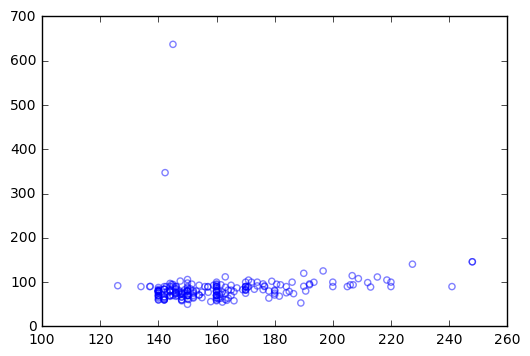

In [14]:
df_bp = df[df.condition == blood]

plt.scatter(df_bp.measure_1, df_bp.measure_2,
         marker='o',
         edgecolor='b',
         facecolor='none',
         alpha=0.5 )
plt.show()

In [15]:
print(df[df.measure_2 > 300])

      patient_id  encounter_id encounter_date  patient_age  measure_1  \
538          288             3     2066-03-03         70.0     142.29   
1084         355             4     2096-09-05         61.0     145.00   

      measure_2     condition condition_medication  \
538      347.29  HYPERTENSION         beta blocker   
1084     637.00  HYPERTENSION                  NaN   

                                         all_medication  is_male  ...    \
538                       beta blocker; statin; insulin        0  ...     
1084  DPP4 inhibitors; metformin; insulin; statin; a...        1  ...     

      nitrate  statin  sulfonylureas  thiazolidinedione  thienopyridine  CAD  \
538         0       1              0                  0               0    1   
1084        0       1              0                  0               0    1   

      DIABETES  HYPERLIPIDEMIA  HYPERTENSION  OBESE  
538          1               0             1      0  
1084         1               0            

In [16]:
#fix bad autoreads manually
for loc, m1, m2 in [(538, 114, 76), (1084, 128.5, 70)]:
    df.loc[loc, 'measure_1'] = m1
    df.loc[loc, 'measure_2'] = m2

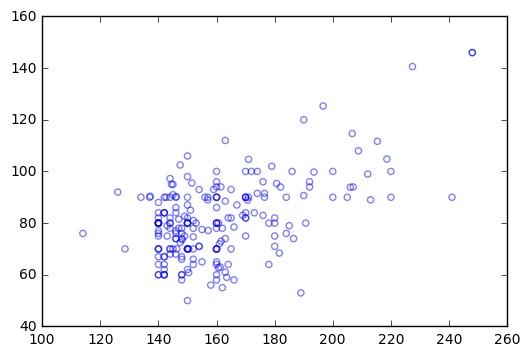

In [17]:
df_bp = df[df.condition == blood]

plt.scatter(df_bp.measure_1, df_bp.measure_2,
         marker='o',
         edgecolor='b',
         facecolor='none',
         alpha=0.5 )
plt.show()

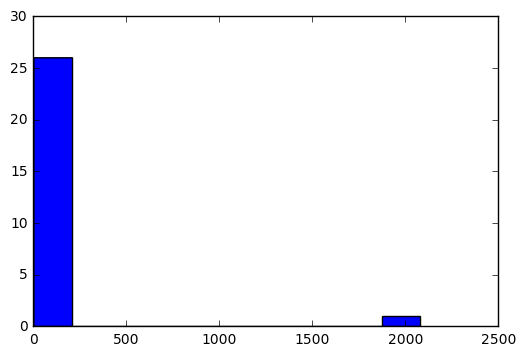

In [18]:
df_sugar = df[df.condition == sugar]
plt.hist(df_sugar.measure_1)
plt.show()

In [19]:
print(df_sugar[df_sugar.measure_1 > 1000])
df.loc[1261, 'measure_1'] = 12

      patient_id  encounter_id encounter_date  patient_age  measure_1  \
1261         393             2     2081-06-10         52.0     2081.0   

      measure_2 condition condition_medication  \
1261        NaN  DIABETES   metformin; insulin   

                                         all_medication  is_male  ...    \
1261  beta blocker; ACE inhibitor; metformin; insuli...        0  ...     

      nitrate  statin  sulfonylureas  thiazolidinedione  thienopyridine  CAD  \
1261        0       0              0                  0               0    1   

      DIABETES  HYPERLIPIDEMIA  HYPERTENSION  OBESE  
1261         1               0             1      0  

[1 rows x 33 columns]


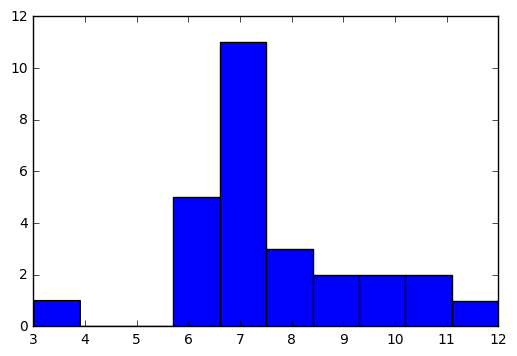

In [20]:
df_sugar = df[df.condition == sugar]
plt.hist(df_sugar.measure_1)
plt.show()

In [21]:
all_diag = [blood, lipid, sugar, cad, fat]

condition_dict = { 'HYPERLIPIDEMIA': ['niacin', 'ezetimibe', 'fibrate'],
                  'CAD': ['thienopyridine', 'aspirin', 'statin'], 
                  'HYPERTENSION': ['beta_blocker', 'ARB', 'nitrate', 'calcium_channel_blocker', 
                                   'ACE_inhibitor', 'diuretic'], 
                  'DIABETES': ['sulfonylureas', 'thiazolidinedione', 
                               'insulin', 'metformin']}

all_meds = [i for x in condition_dict.values() for i in x]
all_meds

['niacin',
 'ezetimibe',
 'fibrate',
 'sulfonylureas',
 'thiazolidinedione',
 'insulin',
 'metformin',
 'beta_blocker',
 'ARB',
 'nitrate',
 'calcium_channel_blocker',
 'ACE_inhibitor',
 'diuretic',
 'thienopyridine',
 'aspirin',
 'statin']

In [22]:
df['bp_systol'] = np.nan
df['bp_diastol'] = np.nan
df['a1c'] = np.nan
df['ldl'] = np.nan

for next_patient in list(set(df.patient_id)):
    patient_data = df[df.patient_id == next_patient]
    for next_encounter in patient_data.encounter_id:
        the_visit = patient_data[patient_data.encounter_id == next_encounter]
        for next_condition in the_visit.condition:
            this_row = the_visit[the_visit.condition == next_condition]
            mask = (df.patient_id == next_patient) & (df.encounter_id == next_encounter)
            if next_condition == blood:
                df.loc[mask, 'bp_systol'] = float(this_row['measure_1'])
                df.loc[mask, 'bp_diastol'] = float(this_row['measure_2'])
            if next_condition == sugar:
                df.loc[mask, 'a1c'] = float(this_row['measure_1'])
            if next_condition == lipid:
                df.loc[mask, 'ldl'] = float(this_row['measure_1'])

df.head()
            

,patient_id,encounter_id,encounter_date,patient_age,measure_1,measure_2,condition,condition_medication,all_medication,is_male,...,thienopyridine,CAD,DIABETES,HYPERLIPIDEMIA,HYPERTENSION,OBESE,bp_systol,bp_diastol,a1c,ldl
1,220,1,2067-05-03,55.0,157.14,77.14,HYPERTENSION,nitrate; beta blocker; calcium channel blocker...,nitrate; beta blocker; calcium channel blocker...,0,...,1,1,0,1,1,0,157.14,77.14,NaN,NaN
6,220,3,2070-12-01,55.0,119.00,NaN,HYPERLIPIDEMIA,NaN,nitrate; beta blocker; calcium channel blocker...,0,...,0,1,0,1,1,0,NaN,NaN,NaN,119.0
9,220,4,2072-07-27,55.0,108.00,NaN,HYPERLIPIDEMIA,NaN,nitrate; beta blocker; calcium channel blocker...,0,...,0,1,0,1,1,1,148.00,76.00,NaN,108.0
11,220,4,2072-07-27,55.0,148.00,76.00,HYPERTENSION,nitrate; beta blocker; calcium channel blocker...,nitrate; beta blocker; calcium channel blocker...,0,...,0,1,0,1,1,1,148.00,76.00,NaN,108.0
16,220,5,2075-01-31,55.0,148.00,66.00,HYPERTENSION,nitrate; beta blocker; calcium channel blocker...,statin; aspirin; nitrate; beta blocker; calciu...,0,...,0,1,1,1,1,1,148.00,66.00,6.55,NaN


In [23]:
new_df = df
new_df = new_df.drop(['condition', 'condition_medication', 'measure_1', 'measure_2'], axis=1)
new_df = new_df.drop_duplicates()

new_df = new_df[np.isfinite(new_df['bp_systol'])] #drop bp NA

    
print(new_df.shape)
new_df.head()

(215, 33)


,patient_id,encounter_id,encounter_date,patient_age,all_medication,is_male,ever_smoked,ACE_inhibitor,ARB,DPP4_inhibitors,...,thienopyridine,CAD,DIABETES,HYPERLIPIDEMIA,HYPERTENSION,OBESE,bp_systol,bp_diastol,a1c,ldl
1,220,1,2067-05-03,55.0,nitrate; beta blocker; calcium channel blocker...,0,1.0,1,0,0,...,1,1,0,1,1,0,157.14,77.14,NaN,NaN
9,220,4,2072-07-27,55.0,nitrate; beta blocker; calcium channel blocker...,0,1.0,1,0,0,...,0,1,0,1,1,1,148.00,76.00,NaN,108.0
16,220,5,2075-01-31,55.0,statin; aspirin; nitrate; beta blocker; calciu...,0,1.0,1,0,0,...,0,1,1,1,1,1,148.00,66.00,6.55,NaN
22,221,2,2089-10-07,65.0,ARB; beta blocker; diuretic; statin,1,0.0,0,1,0,...,0,1,0,1,1,0,155.00,77.50,NaN,NaN
33,222,2,2095-03-27,72.0,beta blocker; metformin,1,NaN,0,0,0,...,0,1,1,1,1,0,146.00,84.00,NaN,138.0


In [24]:
new_df.describe()

,patient_id,encounter_id,patient_age,is_male,ever_smoked,ACE_inhibitor,ARB,DPP4_inhibitors,aspirin,beta_blocker,...,thienopyridine,CAD,DIABETES,HYPERLIPIDEMIA,HYPERTENSION,OBESE,bp_systol,bp_diastol,a1c,ldl
count,215.000000,215.000000,205.00000,215.000000,184.000000,215.000000,215.000000,215.000000,215.000000,215.000000,...,215.000000,215.000000,215.000000,215.000000,215.0,215.000000,215.000000,215.000000,22.000000,11.000000
mean,312.939535,2.753488,64.84878,0.432558,0.423913,0.525581,0.139535,0.004651,0.618605,0.767442,...,0.111628,0.804651,0.767442,0.469767,1.0,0.209302,161.024233,81.584233,7.759708,133.363636
std,50.303482,1.342920,13.74493,0.496587,0.495525,0.500510,0.347312,0.068199,0.486863,0.423449,...,0.315643,0.397394,0.423449,0.500250,0.0,0.407760,22.305330,15.276740,1.944288,35.347624
min,220.000000,1.000000,27.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,114.000000,50.000000,3.010000,100.000000
25%,278.000000,2.000000,NaN,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,1.000000,1.000000,0.000000,1.0,0.000000,146.000000,70.000000,NaN,NaN
50%,309.000000,3.000000,NaN,0.000000,NaN,1.000000,0.000000,0.000000,1.000000,1.000000,...,0.000000,1.000000,1.000000,0.000000,1.0,0.000000,155.000000,80.000000,NaN,NaN
75%,357.000000,4.000000,NaN,1.000000,NaN,1.000000,0.000000,0.000000,1.000000,1.000000,...,0.000000,1.000000,1.000000,1.000000,1.0,0.000000,170.000000,90.000000,NaN,NaN
max,400.000000,5.000000,88.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,248.000000,146.000000,12.000000,196.000000


In [25]:
print(set(new_df[~np.isfinite(new_df.ever_smoked)].patient_id.values))

#256 - past, 288 - Nan, 323 - past, 228 - Nan, 273 - Nan, 297 - Nan, 
#299 - Nan, 332 - Nan, 305 - Nan, 366 - never, 303 - past, 241 -Nan, 
#243 - Nan, 391 - past, 361 - never, 331 - never, 367 -never, 395 - past, 222 - Nan

for patient, smoked in [(256, 1), (323, 1), (366, 0), (303, 1), (391, 1), (361, 0), (331, 0),
                       (367, 0), (395, 1)]:
    new_df.loc[new_df.patient_id == patient, 'ever_smoked'] = smoked
new_df.describe()

set([256, 288, 323, 228, 273, 297, 299, 332, 305, 366, 303, 241, 243, 391, 361, 331, 367, 395, 222])


,patient_id,encounter_id,patient_age,is_male,ever_smoked,ACE_inhibitor,ARB,DPP4_inhibitors,aspirin,beta_blocker,...,thienopyridine,CAD,DIABETES,HYPERLIPIDEMIA,HYPERTENSION,OBESE,bp_systol,bp_diastol,a1c,ldl
count,215.000000,215.000000,205.00000,215.000000,195.000000,215.000000,215.000000,215.000000,215.000000,215.000000,...,215.000000,215.000000,215.000000,215.000000,215.0,215.000000,215.000000,215.000000,22.000000,11.000000
mean,312.939535,2.753488,64.84878,0.432558,0.425641,0.525581,0.139535,0.004651,0.618605,0.767442,...,0.111628,0.804651,0.767442,0.469767,1.0,0.209302,161.024233,81.584233,7.759708,133.363636
std,50.303482,1.342920,13.74493,0.496587,0.495713,0.500510,0.347312,0.068199,0.486863,0.423449,...,0.315643,0.397394,0.423449,0.500250,0.0,0.407760,22.305330,15.276740,1.944288,35.347624
min,220.000000,1.000000,27.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,114.000000,50.000000,3.010000,100.000000
25%,278.000000,2.000000,NaN,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,1.000000,1.000000,0.000000,1.0,0.000000,146.000000,70.000000,NaN,NaN
50%,309.000000,3.000000,NaN,0.000000,NaN,1.000000,0.000000,0.000000,1.000000,1.000000,...,0.000000,1.000000,1.000000,0.000000,1.0,0.000000,155.000000,80.000000,NaN,NaN
75%,357.000000,4.000000,NaN,1.000000,NaN,1.000000,0.000000,0.000000,1.000000,1.000000,...,0.000000,1.000000,1.000000,1.000000,1.0,0.000000,170.000000,90.000000,NaN,NaN
max,400.000000,5.000000,88.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,248.000000,146.000000,12.000000,196.000000


In [26]:
visit_df_list = list()
for __ in xrange(5):
    visit_df_list.append(pd.DataFrame(columns=list(new_df)))

for next_patient in list(set(new_df.patient_id)):
    patient_data = new_df[new_df.patient_id == next_patient]
    encounters = list(set(patient_data.encounter_id))
    encounters.sort()
    for index, each_encounter in enumerate(encounters):
        the_visit = patient_data[patient_data.encounter_id == each_encounter]
        visit_df_list[index] = visit_df_list[index].append(the_visit)  

for x in xrange(5):
    print(len(visit_df_list[x].patient_id))

97
67
36
13
2


In [27]:
for visit in visit_df_list:
    print(visit.shape)

visit_df_list[0].describe()

(97, 33)
(67, 33)
(36, 33)
(13, 33)
(2, 33)


,patient_id,encounter_id,patient_age,is_male,ever_smoked,ACE_inhibitor,ARB,DPP4_inhibitors,aspirin,beta_blocker,...,thienopyridine,CAD,DIABETES,HYPERLIPIDEMIA,HYPERTENSION,OBESE,bp_systol,bp_diastol,a1c,ldl
count,97.000000,97.000000,91.000000,97.000000,87.000000,97.000000,97.000000,97.0,97.000000,97.000000,...,97.000000,97.000000,97.000000,97.000000,97.0,97.000000,97.000000,97.000000,11.000000,4.000000
mean,307.659794,1.917526,64.384615,0.494845,0.448276,0.474227,0.103093,0.0,0.567010,0.721649,...,0.103093,0.773196,0.752577,0.432990,1.0,0.195876,156.211649,81.638866,7.835000,138.750000
std,51.424072,1.187347,12.794764,0.502571,0.500200,0.501929,0.305660,0.0,0.498063,0.450515,...,0.305660,0.420940,0.433756,0.498063,0.0,0.398935,19.294035,13.698396,2.293819,38.448017
min,220.000000,1.000000,27.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,114.000000,58.000000,3.010000,102.000000
25%,270.000000,1.000000,NaN,0.000000,NaN,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,1.000000,1.000000,0.000000,1.0,0.000000,144.000000,70.000000,NaN,NaN
50%,305.000000,1.000000,NaN,0.000000,NaN,0.000000,0.000000,0.0,1.000000,1.000000,...,0.000000,1.000000,1.000000,0.000000,1.0,0.000000,150.000000,80.000000,NaN,NaN
75%,353.000000,3.000000,NaN,1.000000,NaN,1.000000,0.000000,0.0,1.000000,1.000000,...,0.000000,1.000000,1.000000,1.000000,1.0,0.000000,163.000000,90.000000,NaN,NaN
max,400.000000,5.000000,87.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,241.000000,125.330000,12.000000,192.000000


In [28]:
for index, visit in enumerate(visit_df_list):
    visit['visit_id'] = index + 1

all_df = pd.concat(visit_df_list)
all_df.head()

,patient_id,encounter_id,encounter_date,patient_age,all_medication,is_male,ever_smoked,ACE_inhibitor,ARB,DPP4_inhibitors,...,CAD,DIABETES,HYPERLIPIDEMIA,HYPERTENSION,OBESE,bp_systol,bp_diastol,a1c,ldl,visit_id
1,220.0,1.0,2067-05-03,55.0,nitrate; beta blocker; calcium channel blocker...,0.0,1.0,1.0,0.0,0.0,...,1.0,0.0,1.0,1.0,0.0,157.14,77.14,NaN,NaN,1
22,221.0,2.0,2089-10-07,65.0,ARB; beta blocker; diuretic; statin,1.0,0.0,0.0,1.0,0.0,...,1.0,0.0,1.0,1.0,0.0,155.00,77.50,NaN,NaN,1
33,222.0,2.0,2095-03-27,72.0,beta blocker; metformin,1.0,NaN,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,0.0,146.00,84.00,NaN,138.0,1
62,224.0,3.0,2085-11-05,65.0,fibrate; nitrate; beta blocker; diuretic; stat...,1.0,1.0,0.0,0.0,0.0,...,1.0,0.0,1.0,1.0,0.0,150.00,90.00,NaN,NaN,1
82,225.0,4.0,2095-12-04,71.0,fibrate; statin; thienopyridine; aspirin; nitr...,1.0,1.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,0.0,146.00,77.00,NaN,NaN,1


In [29]:
#drop unwated columns
df_edit = all_df.drop(['all_medication', 'HYPERTENSION', 'a1c', 'ldl'], axis=1)
df_edit.head()

,patient_id,encounter_id,encounter_date,patient_age,is_male,ever_smoked,ACE_inhibitor,ARB,DPP4_inhibitors,aspirin,...,sulfonylureas,thiazolidinedione,thienopyridine,CAD,DIABETES,HYPERLIPIDEMIA,OBESE,bp_systol,bp_diastol,visit_id
1,220.0,1.0,2067-05-03,55.0,0.0,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,1.0,0.0,1.0,0.0,157.14,77.14,1
22,221.0,2.0,2089-10-07,65.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,155.00,77.50,1
33,222.0,2.0,2095-03-27,72.0,1.0,NaN,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,1.0,0.0,146.00,84.00,1
62,224.0,3.0,2085-11-05,65.0,1.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,1.0,0.0,1.0,0.0,150.00,90.00,1
82,225.0,4.0,2095-12-04,71.0,1.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,1.0,1.0,1.0,0.0,146.00,77.00,1


In [30]:
for cond in [lipid, cad, sugar]:
    for med in condition_dict[cond]:
        if med != 'beta blocker': #only med for 2 conditions
            df_edit.loc[df_edit[med] == 1, cond] = 1
print(df_edit.shape)
df_edit.describe()

(215, 30)


,patient_id,encounter_id,patient_age,is_male,ever_smoked,ACE_inhibitor,ARB,DPP4_inhibitors,aspirin,beta_blocker,...,sulfonylureas,thiazolidinedione,thienopyridine,CAD,DIABETES,HYPERLIPIDEMIA,OBESE,bp_systol,bp_diastol,visit_id
count,215.000000,215.000000,205.00000,215.000000,195.000000,215.000000,215.000000,215.000000,215.000000,215.000000,...,215.000000,215.000000,215.000000,215.000000,215.000000,215.000000,215.000000,215.000000,215.000000,215.000000
mean,312.939535,2.753488,64.84878,0.432558,0.425641,0.525581,0.139535,0.004651,0.618605,0.767442,...,0.223256,0.079070,0.111628,0.804651,0.767442,0.469767,0.209302,161.024233,81.584233,1.865116
std,50.303482,1.342920,13.74493,0.496587,0.495713,0.500510,0.347312,0.068199,0.486863,0.423449,...,0.417400,0.270477,0.315643,0.397394,0.423449,0.500250,0.407760,22.305330,15.276740,0.964531
min,220.000000,1.000000,27.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,114.000000,50.000000,1.000000
25%,278.000000,2.000000,NaN,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,146.000000,70.000000,1.000000
50%,309.000000,3.000000,NaN,0.000000,NaN,1.000000,0.000000,0.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,155.000000,80.000000,2.000000
75%,357.000000,4.000000,NaN,1.000000,NaN,1.000000,0.000000,0.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,170.000000,90.000000,2.000000
max,400.000000,5.000000,88.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,248.000000,146.000000,5.000000


In [31]:
df_edit.insert(0, 'bp_systol_delta', np.nan)
df_edit.insert(0, 'bp_diastol_delta', np.nan)

df_edit.insert(0, 'bp_systol_score', np.nan)
df_edit.insert(0, 'bp_diastol_score', np.nan)

df_edit.insert(0, 'bp_systol_distance', np.nan)
df_edit.insert(0, 'bp_diastol_distance', np.nan)

In [32]:
healthy_dict = {'systol': (120, 90), 'diastol': (80, 60)}

def distance_from_healthly(actual, bp_type):
    healthy_max, healthy_min = healthy_dict[bp_type]
    if healthy_min < actual < healthy_max:
        return 0
    dist_above = abs(healthy_max - actual)
    dist_below = abs(healthy_min - actual)
    shortest = min([dist_above, dist_below])
    mean_scale = (healthy_max + healthy_min) / float(2)
    return shortest/ mean_scale

distance_from_healthly(110, 'diastol')

0.42857142857142855

In [33]:
df_edit['bp_systol_distance'] = [distance_from_healthly(x, 'systol') for x in df_edit['bp_systol']]
df_edit['bp_diastol_distance'] = [distance_from_healthly(x, 'diastol') for x in df_edit['bp_diastol']]
df_edit['bp_hypot'] = [math.sqrt( (s*s) + (d*d) ) for s, d in zip(df_edit.bp_systol_distance, df_edit.bp_diastol_distance)]

In [34]:
for each_patient in set(df_edit.patient_id.values):
    patient_mask = (df_edit.patient_id == each_patient)
    this_patient = df_edit[patient_mask]
    for each_visit in this_patient.visit_id.values:
        this_visit_mask = patient_mask & (df_edit.visit_id == each_visit)
        next_visit_mask = patient_mask & (df_edit.visit_id == each_visit + 1)
        next_vist = df_edit[next_visit_mask]
        
        if len(df_edit.loc[next_visit_mask,'bp_systol'].values) > 0:
            df_edit.loc[this_visit_mask,'bp_systol_delta'] = (float(df_edit.loc[this_visit_mask,'bp_systol'].values) - 
                                                         float(df_edit.loc[next_visit_mask,'bp_systol'].values))
            df_edit.loc[this_visit_mask,'bp_diastol_delta'] = (float(df_edit.loc[this_visit_mask,'bp_diastol'].values) - 
                                                          float(df_edit.loc[next_visit_mask,'bp_diastol'].values))
            
            df_edit.loc[this_visit_mask,'bp_systol_score'] = (float(df_edit.loc[this_visit_mask,'bp_systol_distance'].values) - 
                                                         float(df_edit.loc[next_visit_mask,'bp_systol_distance'].values))
            df_edit.loc[this_visit_mask,'bp_diastol_score'] = (float(df_edit.loc[this_visit_mask,'bp_diastol_distance'].values) - 
                                                          float(df_edit.loc[next_visit_mask,'bp_diastol_distance'].values))
            df_edit.loc[this_visit_mask, 'bp_hypot_score'] = (float(df_edit.loc[this_visit_mask,'bp_hypot'].values) - 
                                                          float(df_edit.loc[next_visit_mask,'bp_hypot'].values))

        
df_edit[df_edit.visit_id == 2].describe()
        

,bp_diastol_distance,bp_systol_distance,bp_diastol_score,bp_systol_score,bp_diastol_delta,bp_systol_delta,patient_id,encounter_id,patient_age,is_male,...,thienopyridine,CAD,DIABETES,HYPERLIPIDEMIA,OBESE,bp_systol,bp_diastol,visit_id,bp_hypot,bp_hypot_score
count,67.000000,67.000000,36.000000,36.000000,36.000000,36.000000,67.000000,67.000000,64.000000,67.000000,...,67.000000,67.000000,67.000000,67.000000,67.000000,67.000000,67.000000,67.0,67.000000,36.000000
mean,0.092712,0.412738,0.028345,0.003730,3.092500,0.391667,314.791045,3.029851,65.703125,0.402985,...,0.134328,0.850746,0.820896,0.477612,0.194030,163.337463,80.661493,2.0,0.435570,0.012530
std,0.172435,0.230307,0.174192,0.257691,16.732029,27.057509,49.458136,1.029418,14.236862,0.494200,...,0.343578,0.359028,0.386334,0.503268,0.398437,24.182201,16.570019,0.0,0.268027,0.285752
min,0.000000,0.080952,-0.342857,-0.495238,-48.000000,-52.000000,220.000000,2.000000,27.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,128.500000,53.000000,2.0,0.080952,-0.523810
25%,0.000000,0.238095,NaN,NaN,NaN,NaN,280.000000,2.000000,NaN,0.000000,...,0.000000,1.000000,1.000000,0.000000,0.000000,145.000000,70.000000,2.0,0.260396,NaN
50%,0.014286,0.352381,NaN,NaN,NaN,NaN,320.000000,3.000000,NaN,0.000000,...,0.000000,1.000000,1.000000,0.000000,0.000000,157.000000,80.000000,2.0,0.373286,NaN
75%,0.142857,0.561905,NaN,NaN,NaN,NaN,356.000000,4.000000,NaN,1.000000,...,0.000000,1.000000,1.000000,1.000000,0.000000,179.000000,90.000000,2.0,0.561905,NaN
max,0.942857,1.219048,0.738714,0.540286,51.710000,56.730000,400.000000,5.000000,88.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,248.000000,146.000000,2.0,1.541122,0.841033


In [35]:
df_edit.columns.tolist()

row_identifiers = ['patient_id', 'encounter_id', 'encounter_date', 'visit_id']
bp_measures = ['bp_systol', 'bp_systol_delta', 'bp_systol_distance',
               'bp_diastol', 'bp_diastol_delta', 'bp_diastol_distance',
              'bp_hypot', 'bp_hypot_score']

demographics = ['patient_age', 'is_male', 'ever_smoked']
conditions = ['CAD', 'DIABETES', 'HYPERLIPIDEMIA', 'OBESE']
drugs = ['ACE_inhibitor', 'ARB', 'DPP4_inhibitors', 'aspirin', 'beta_blocker', 
         'calcium_channel_blocker', 'diuretic', 'ezetimibe', 'fibrate', 'insulin', 
         'metformin', 'niacin', 'nitrate', 'statin', 'sulfonylureas',
         'thiazolidinedione', 'thienopyridine']
factors = demographics + conditions + drugs

new_col_order = row_identifiers + bp_measures + factors

df_edit = df_edit[new_col_order]
df_edit.head()

,patient_id,encounter_id,encounter_date,visit_id,bp_systol,bp_systol_delta,bp_systol_distance,bp_diastol,bp_diastol_delta,bp_diastol_distance,...,ezetimibe,fibrate,insulin,metformin,niacin,nitrate,statin,sulfonylureas,thiazolidinedione,thienopyridine
1,220.0,1.0,2067-05-03,1,157.14,9.14,0.353714,77.14,1.14,0.000000,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
22,221.0,2.0,2089-10-07,1,155.00,NaN,0.333333,77.50,NaN,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
33,222.0,2.0,2095-03-27,1,146.00,NaN,0.247619,84.00,NaN,0.057143,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
62,224.0,3.0,2085-11-05,1,150.00,NaN,0.285714,90.00,NaN,0.142857,...,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
82,225.0,4.0,2095-12-04,1,146.00,NaN,0.247619,77.00,NaN,0.000000,...,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0


In [36]:
all_delta_df = df_edit[np.isfinite(df_edit['bp_systol_delta'])]
all_delta_df.describe()

,patient_id,encounter_id,visit_id,bp_systol,bp_systol_delta,bp_systol_distance,bp_diastol,bp_diastol_delta,bp_diastol_distance,bp_hypot,...,ezetimibe,fibrate,insulin,metformin,niacin,nitrate,statin,sulfonylureas,thiazolidinedione,thienopyridine
count,118.000000,118.000000,118.000000,118.000000,118.000000,118.000000,118.000000,118.000000,118.000000,118.000000,...,118.000000,118.000000,118.000000,118.000000,118.000000,118.000000,118.000000,118.000000,118.000000,118.000000
mean,317.279661,2.025424,1.576271,160.715000,-4.265339,0.387762,83.475169,1.935847,0.108982,0.419630,...,0.008475,0.025424,0.262712,0.220339,0.016949,0.203390,0.500000,0.228814,0.093220,0.076271
std,49.157150,1.008188,0.755683,22.832955,23.971143,0.217457,16.604722,16.071774,0.186958,0.261284,...,0.092057,0.158080,0.441984,0.416243,0.129631,0.404237,0.502132,0.421860,0.291981,0.266563
min,220.000000,1.000000,1.000000,126.000000,-60.000000,0.057143,58.000000,-48.000000,0.000000,0.180702,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,282.500000,1.000000,1.000000,144.000000,-20.600000,0.228571,74.000000,-6.750000,0.000000,0.234667,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,321.000000,2.000000,1.000000,153.500000,-4.000000,0.319048,80.000000,1.000000,0.000000,0.362571,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000
75%,358.750000,3.000000,2.000000,170.000000,10.000000,0.476190,90.000000,10.000000,0.142857,0.497157,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
max,400.000000,4.000000,4.000000,248.000000,56.730000,1.219048,146.000000,52.000000,0.942857,1.541122,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [37]:
print(set(all_delta_df[~np.isfinite(all_delta_df.ever_smoked)].patient_id.values))
print(set(all_delta_df[~np.isfinite(all_delta_df.patient_age)].patient_id.values))

all_delta_df.shape

set([228.0, 305.0, 297.0, 332.0, 241.0, 243.0])
set([282.0, 228.0, 279.0])


(118, 36)

In [38]:
#creats list of patient id with 1,2,3 etc visit each

id_groups = list()

for x in xrange(1, 6):
    id_groups.append(all_delta_df[all_delta_df.visit_id == x].patient_id.values.tolist())
id_groups

for top_level in xrange(4, 0, -1):
    for sub_level in xrange(top_level - 1, -1, -1):
        id_groups[sub_level] = [x for x in id_groups[sub_level] if x not in id_groups[top_level]]

print(id_groups)

[[228.0, 243.0, 249.0, 252.0, 255.0, 257.0, 270.0, 272.0, 282.0, 290.0, 292.0, 303.0, 305.0, 306.0, 308.0, 322.0, 323.0, 327.0, 328.0, 332.0, 336.0, 352.0, 354.0, 355.0, 362.0, 363.0, 365.0, 394.0, 395.0, 398.0, 399.0], [220.0, 240.0, 241.0, 242.0, 244.0, 250.0, 256.0, 279.0, 281.0, 284.0, 291.0, 301.0, 307.0, 309.0, 320.0, 321.0, 326.0, 329.0, 331.0, 339.0, 357.0, 358.0, 396.0], [258.0, 286.0, 304.0, 351.0, 359.0, 360.0, 361.0, 367.0, 391.0, 393.0, 400.0], [297.0, 325.0], []]


In [218]:
train_ids = list()
for x in xrange(0, 4):
    sample_size = int(round(len(id_groups[x]) * 0.8, 0))
    chosen_patients = random.sample(id_groups[x], sample_size)
    train_ids.append(chosen_patients)

train_ids = [y for x in train_ids for y in x]
    
train = all_delta_df[all_delta_df.patient_id.isin(train_ids)]
test = all_delta_df[~ all_delta_df.patient_id.isin(train_ids)]

print(test.shape)
print(train.shape)

(22, 36)
(96, 36)


In [219]:
train.to_csv('train_data.csv')
test.to_csv('test_data.csv')